# Housing and Homelessness

In [2]:
# Dependencies
import pandas as pd
import numpy as np
import requests
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import linregress

# US Census setup
from census import Census
from us import states
from config import census_key

## US Census Data
- API Dataset - American COmmuity Survey 5 year estimates
- Pulled data by county for 2017-2021 (no data available for 2022)

In [ ]:
# Define function to retrieve US censue data for a specfic year and return a dataframe
def get_census_data(year):
    census_library = Census(census_key, year=year)
    state_code = states.CA.fips
    variables = [
        'NAME',
        'B01003_001E',  # Population
        'B25014_001E',  # Total Housing units or B25001_001E
        'B25014_005E',  # Housing units owner occupied, 1-1.5 occupants per room
        'B25014_006E',  # Housing units owner occupied, 1.5-2 occupants per room
        'B25014_007E',  # Housing units owner occupied, >2 occupants per room
        'B25014_011E',  # Housing units renter occupied, 1-1.5 occupants per room
        'B25014_012E',  # Housing units renter occupied, 1.5-2 occupants per room
        'B25014_013E',  # Housing units renter occupied, >2 occupants per room   
        'B25106_003E',  # Housing units owner occupied, income <20K
        'B25106_006E',  # Housing units owner occupied, income <20K, housing costs >=30% of income
        'B25106_007E',  # Housing units owner occupied, income 20-35K
        'B25106_010E',  # Housing units owner occupied, income 20-35K, housing costs >=30% of income
        'B25106_011E',  # Housing units owner occupied, income 35-50K
        'B25106_014E',  # Housing units owner occupied, income 35-50K, housing costs >=30% of income
        'B25106_015E',  # Housing units owner occupied, income 50-75K
        'B25106_018E',  # Housing units owner occupied, income 50-75K, housing costs >=30% of income
        'B25106_019E',  # Housing units owner occupied, income >75K
        'B25106_022E',  # Housing units owner occupied, income >75K, housing costs >=30% of income
        'B25106_025E',  # Housing units renter occupied, income <20K
        'B25106_028E',  # Housing units renter occupied, income <20K, housing costs >=30% of income
        'B25106_029E',  # Housing units renter occupied, income 20-35K
        'B25106_032E',  # Housing units renter occupied, income 20-35K, housing costs >=30% of income
        'B25106_033E',  # Housing units renter occupied, income 35-50K
        'B25106_036E',  # Housing units renter occupied, income 35-50K, housing costs >=30% of income
        'B25106_037E',  # Housing units renter occupied, income 50-75K
        'B25106_040E',  # Housing units renter occupied, income 50-75K, housing costs >=30% of income
        'B25106_041E',  # Housing units renter occupied, income >75K
        'B25106_044E'   # Housing units renter occupied, income >75K, housing costs >=30% of income 
    ]

    # Retrieve data for all counties in California
    data = census_library.acs5.state_county(variables, state_code, Census.ALL)

    # Convert to dataframe
    df = pd.DataFrame(data)
    df['Year'] = year

    # Return the dataframe
    return df

In [ ]:
# Retrieve census data for multiple years and merge into one dataframe
years = [2017, 2018, 2019, 2020, 2021]

# https://blog.finxter.com/how-to-create-a-python-list-of-size-n/
year_df = [None] * len(years)
for year in years:
    year_df[year - 2017] = get_census_data(year)

# https://www.geeksforgeeks.org/merge-two-dataframes-with-same-column-names/
housing_df = pd.concat(year_df, axis=0)

# Export raw data to csv
file_path = Path('output_data/housing_raw_data.csv')
housing_df.to_csv(file_path, index=False)

housing_df

In [3]:
# Use this to recreate dataframe if starting a new Jupyter session or Kernal
file_path = Path('output_data/housing_raw_data.csv')
housing_df = pd.read_csv(file_path)

In [4]:
# Clean up data and add calculated columns

# Rename existing columns
housing_df = housing_df.rename(
    columns = {
        'NAME': 'County',
        'B01003_001E': 'Population',
        'B25014_001E': 'Total Housing Units'
    }
)

# Remove California from data in County column
housing_df['County'] = housing_df['County'].str.replace(', California','')

# Add columns rolling up data on overcrowded housing units
housing_df['Units Overcrowded'] = housing_df['B25014_005E'] + housing_df['B25014_011E']
housing_df['Units Severely Overcrowded'] = (housing_df['B25014_006E'] + housing_df['B25014_007E'] +
                                            housing_df['B25014_012E'] + housing_df['B25014_013E']
                                           )

# Add columns rolling up data on housing units based on housing costs and household income
housing_df['Units Income < 50K'] = (housing_df['B25106_003E'] + housing_df['B25106_007E'] +
                                    housing_df['B25106_011E'] + housing_df['B25106_015E'] +
                                    housing_df['B25106_019E'] + housing_df['B25106_025E'] +
                                    housing_df['B25106_029E'] + housing_df['B25106_033E'] +
                                    housing_df['B25106_037E'] + housing_df['B25106_041E']
                                   )
housing_df['Units Costs >= 30%'] = (housing_df['B25106_006E'] + housing_df['B25106_010E'] +
                                    housing_df['B25106_014E'] + housing_df['B25106_018E'] + 
                                    housing_df['B25106_022E'] + housing_df['B25106_028E'] +
                                    housing_df['B25106_032E'] + housing_df['B25106_036E'] +
                                    housing_df['B25106_040E'] + housing_df['B25106_044E']
                                   )

# Remove unneeded columns
# https://sparkbyexamples.com/pandas/pandas-drop-columns-by-index/
housing_clean_df = housing_df.drop(housing_df.iloc[:, 3:31], axis = 1)

# Export clean data to csv
file_path = Path('output_data/housing_clean_2021.csv')
housing_clean_df.to_csv(file_path, index=False)

# Print the dataframe
housing_clean_df.head()

,County,Population,Total Housing Units,Year,Units Overcrowded,Units Severely Overcrowded,Units Income < 50K,Units Costs >= 30%
0,Merced County,267390.0,79261.0,2017,5576.0,1711.0,75447.0,29818.0
1,Lake County,64095.0,26327.0,2017,505.0,275.0,24890.0,10623.0
2,Mariposa County,17658.0,7434.0,2017,76.0,37.0,7110.0,2378.0
3,Modoc County,9017.0,3638.0,2017,80.0,17.0,3458.0,1191.0
4,Yuba County,74644.0,25880.0,2017,1209.0,534.0,25061.0,10093.0


## Continuum of Care (CoC) Mapping
- Homelessness data is summarized by CoC not county.
- Matt created a csv file to map CoCs to counties so CoCs can be added to the housing dataframe and merged with homeless data.

In [9]:
# Create final housing dataframe that includes CoC

# Create dataframe with CoC data
file_path = Path('Resources/County-CoC Mapping.csv')
coc_mapping = pd.read_csv(file_path)

# Create dataframe with housing and CoC data
housing_coc_df = pd.merge(housing_clean_df, coc_mapping, on=['County'], how='left')
housing_coc_df = housing_coc_df.groupby(['Year', 'Continuum of Care']).sum(numeric_only=True).reset_index()

# Display # of rows and dataframe
print(f'Number of rows: {len(housing_coc_df)}')
housing_coc_df.head()

Number of records: 205


,Year,Continuum of Care,Population,Total Housing Units,Units Overcrowded,Units Severely Overcrowded,Units Income < 50K,Units Costs >= 30%
0,2017,Alameda County CoC,1629615.0,569070.0,27872.0,13657.0,556059.0,218874.0
1,2017,"Alpine, Inyo, Mono Counties CoC",33456.0,13229.0,196.0,64.0,12584.0,4244.0
2,2017,"Amador, Calaveras, Mariposa, Tuolumne Counties...",153920.0,61698.0,1032.0,314.0,59610.0,22211.0
3,2017,Butte County CoC,225207.0,86167.0,1879.0,685.0,83319.0,34750.0
4,2017,"Colusa, Glenn, Trinity Counties CoC",62451.0,22445.0,935.0,270.0,21382.0,7738.0


## CA Open Portal Data
- Dataset - Excel files with annual demographics for people experiencing homelessness between 2017 and 2022
- Note: There was no dataset that contained homeless 

In [10]:
# Use this to recreate dataframe if starting a new Jupyter session or Kernal
file_path = Path('resources/experiencing_homelessness_age_demographics.csv')
homeless_df = pd.read_csv(file_path)

In [12]:
# Clean up homeless data and prep to merge with housing data

# Rename existing columns
homeless_df = homeless_df.rename(
    columns = {
        'CALENDAR_YEAR': 'Year',
        'COC_ID': 'CoC Code',
        'COC_NAME': 'Continuum of Care',
        'EXPERIENCING_HOMELESSNESS_CNT': 'Homeless Count'
    }
)

# Change homeless count data type to integer
homeless_df = homeless_df.loc[homeless_df['Homeless Count']!='*']
homeless_df['Homeless Count'] = homeless_df['Homeless Count'].astype(int)

# Remove counts for all of California
homeless_df = homeless_df.loc[homeless_df['Continuum of Care'] != 'California']

# Rename multiple CoCs in LA so they roll up into one number per year
la_cocs = ['Glendale CoC (Los Angeles County)', 'Pasadena CoC (Los Angeles County)', 'Long Beach CoC (Los Angeles County)']
homeless_df['Continuum of Care'] = homeless_df['Continuum of Care'].replace(la_cocs, 'Los Angeles County CoC')

# Group by year and COC name and sum homeless counts
homeless_df = homeless_df.groupby(['Year', 'Continuum of Care'])['Homeless Count'].sum().reset_index()

# Display # of rows and dataframe
print(f'Number of rows: {len(homeless_df)}')
homeless_df.head()

Number of rows: 244


,Year,Continuum of Care,Homeless Count
0,2017,Alameda County CoC,6713
1,2017,"Alpine, Inyo, Mono Counties CoC",151
2,2017,"Amador, Calaveras, Mariposa, Tuolumne Counties...",368
3,2017,Butte County CoC,1400
4,2017,"Colusa, Glenn, Trinity Counties CoC",190


## Final Dataframe with Housing and Homeless Data

In [232]:
# Create final dataframe merging housing and homeless data
final_df = pd.merge(housing_coc_df, homeless_df, on=['Year','Continuum of Care'], how='left')

# Add columns to calculate %s of overcrowded units
final_df['% Units Overcrowded'] = (final_df['Units Overcrowded'] /
                                   final_df['Total Housing Units']) * 100
final_df['% Units Severely Overcrowded'] = (final_df['Units Severely Overcrowded'] /
                                            final_df['Total Housing Units']) * 100
final_df['% Units All Overcrowded'] = ((final_df['Units Overcrowded'] +
                                        final_df['Units Severely Overcrowded']) /
                                       final_df['Total Housing Units']) * 100

# Add columns to calculate % of housing units with costs >= 30%
final_df['% Units Inc < 50K Costs >= 30%'] = (final_df['Units Costs >= 30%'] /
                                              final_df['Units Income < 50K']) * 100
final_df['% Units Costs >= 30%'] = (final_df['Units Costs >= 30%'] /
                                    final_df['Total Housing Units']) * 100

# Add column to calculation homeless % of population
final_df['% Homeless'] = (final_df['Homeless Count'] /
                          final_df['Population']) * 100

# Reorganize columns
#final_df = final_df[['Year', 'Continuum of Care','Population', 'Homeless Count',
#                     '% Homeless', 'Total Housing Units', 'Units Severely Overcrowded',
#                     '% Units Severely Overcrowded', '% Units Costs > 30%'
#                    ]]

# Drop rows for CoCs with missing data
# final_df = final_df.loc[final_df['Continuum of Care'] != 'Yuba, Sutter Counties CoC']
final_df = final_df.fillna(0)

# Export final data to csv
file_path = Path('output_data/housing_final_data.csv')
final_df.to_csv(file_path, index=False)

# Display # of rows and dataframe
print(f'Number of rows: {len(final_df)}')
final_df.head()

Number of rows: 205


,Year,Continuum of Care,Population,Total Housing Units,Units Overcrowded,Units Severely Overcrowded,Units Income < 50K,Units Costs >= 30%,Homeless Count,% Units Overcrowded,% Units Severely Overcrowded,% Units All Overcrowded,% Units Inc < 50K Costs >= 30%,% Units Costs >= 30%,% Homeless
0,2017,Alameda County CoC,1629615.0,569070.0,27872.0,13657.0,556059.0,218874.0,6713.0,4.897816,2.399881,7.297696,39.361650,38.461701,0.411938
1,2017,"Alpine, Inyo, Mono Counties CoC",33456.0,13229.0,196.0,64.0,12584.0,4244.0,151.0,1.481593,0.483786,1.965379,33.725366,32.081034,0.451339
2,2017,"Amador, Calaveras, Mariposa, Tuolumne Counties...",153920.0,61698.0,1032.0,314.0,59610.0,22211.0,368.0,1.672664,0.508931,2.181594,37.260527,35.999546,0.239085
3,2017,Butte County CoC,225207.0,86167.0,1879.0,685.0,83319.0,34750.0,1400.0,2.180649,0.794968,2.975617,41.707174,40.328664,0.621650
4,2017,"Colusa, Glenn, Trinity Counties CoC",62451.0,22445.0,935.0,270.0,21382.0,7738.0,190.0,4.165738,1.202941,5.368679,36.189318,34.475384,0.304239


## Analysis and Visualizations

### Functions for Visualizations

In [262]:
# Function to create Linear Regression plots
def plot_lin_reg(x_values, y_values, parems):
    
    # Set variables for linear regression and plot
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = 'y = ' + str(round(slope,2)) + 'x + ' + str(round(intercept,2))
    plt.scatter(x_values,y_values)
    plt.plot(x_values,regress_values,'r-')
    
    # Set location of regression equation - x is 5% to the right of the y axis
    xmin, xmax = plt.xlim()
    line_eq_xloc = round(xmin + ((xmax - xmin)* .05), 1)
    
    # Increase ylim max by 10% and set location for regression equation - y is 1% above previous ylim max
    ymin, ymax = plt.ylim()
    plt.ylim(ymin, round(ymax + ((ymax - ymin) * .10), 1))
    line_eq_yloc = round(ymax + ((ymax - ymin) * .01), 1)     

    # Add equation, set x/y axis labels and title
    plt.annotate(line_eq,(line_eq_xloc, line_eq_yloc), fontsize=15, color='red')
    plt.xlabel(parems['x'], fontsize=12, labelpad=6)
    plt.ylabel(parems['y'], fontsize=12, labelpad=2)
    plt.title(parems['title'], fontsize=14, pad=15, wrap=True)
    
    # Print statisical information
    print(f'The correlation is: {st.pearsonr(x_values,y_values)[0]}')
    print(f'The r value is: {rvalue}')
    print(f'The p value is: {pvalue}')
    
    # Save chart as an image
    plt.savefig(parems['png_path'])
    
    # Display linear regression
    plt.show()

In [269]:
# Function to create line chart with 2 different y axes
def plot_line_2y(df, parems):
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    # Setup axes labels and tick
    ax1.set_xlabel(parems['x'], fontsize=12, labelpad=6)
    ax1.set_ylabel(parems['y1'], fontsize=12, labelpad=4, color=parems['colors'][0])
    ax2.set_ylabel(parems['y2'], fontsize=12, labelpad=4, color=parems['colors'][1])
    ax1.tick_params(axis='y', labelcolor=parems['colors'][0])
    ax2.tick_params(axis='y', labelcolor=parems['colors'][1])
    
    # Setup bar chart
    ax1.plot(df.iloc[:, 0], df.iloc[:, 1], color=parems['colors'][0])
    ax2.plot(df.iloc[:, 0], df.iloc[:, 2], color=parems['colors'][1])
    
    # Set xticks and title
    plt.xticks(df.iloc[:, 0])
    plt.title(parems['title'], fontsize=14, pad=15, wrap=True)
    
    # Save the figure
    plt.savefig(parems['png_path'], bbox_inches = 'tight')
    
    # Display line chart
    plt.show()

In [268]:
# Function to create bar chart with 2 different y axes
# Code reference: https://stackoverflow.com/questions/64857641/how-to-add-multiple-y-axis-to-bar-plot-in-matplotlib
def plot_bar_2y(df, parems):
    
    x = np.arange(len(df))
    
    width = 0.4
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()  
    
    # Setup axes labels and ticks
    ax1.set_xlabel(parems['x'], fontsize=12, labelpad=6)
    ax1.set_ylabel(parems['y1'], fontsize=12, labelpad=4, color=parems['colors'][0]) 
    ax2.set_ylabel(parems['y2'], fontsize=12, labelpad=4, color=parems['colors'][1])
    ax1.tick_params(axis='y', labelcolor=parems['colors'][0])
    ax2.tick_params(axis='y', labelcolor=parems['colors'][1])
    
    # Setup bar chart
    ax1.bar(x-(width/2), df.iloc[:, 1], width=width, color=parems['colors'][0])
    ax2.bar(x+(width/2), df.iloc[:, 2], width=width, color=parems['colors'][1])       
    
    # Reset x ticks and set title
    ax1.set_xticks(x)
    ax1.set_xticklabels(df.iloc[:, 0], rotation=parems['rot'], ha = 'right')
    plt.title(parems['title'], fontsize=14, pad=15, wrap=True)
    
    # Save the figure
    fig.savefig(parems['png_path'], bbox_inches = 'tight')
    
    # Display line chart
    plt.show()

### Summary Statistics

In [274]:
final_df.describe()

,Year,Population,Total Housing Units,Units Overcrowded,Units Severely Overcrowded,Units Income < 50K,Units Costs >= 30%,Homeless Count,% Units Overcrowded,% Units Severely Overcrowded,% Units All Overcrowded,% Units Inc < 50K Costs >= 30%,% Units Costs >= 30%,% Homeless
count,205.000000,2.050000e+02,2.050000e+02,205.000000,205.000000,2.050000e+02,2.050000e+02,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,2019.000000,9.571536e+05,3.181392e+05,16741.307317,9394.312195,3.095656e+05,1.296345e+05,5899.946341,4.263872,2.006444,6.270317,39.302402,38.118400,0.592305
std,1.417676,1.659237e+06,5.452299e+05,35174.180641,24538.729650,5.295913e+05,2.472653e+05,13342.314791,1.826856,1.088808,2.738969,3.065238,3.033209,0.320139
min,2017.000000,3.332600e+04,1.306500e+04,196.000000,11.000000,1.245900e+04,3.870000e+03,0.000000,1.061722,0.083151,1.737664,31.061883,29.621125,0.000000
25%,2018.000000,1.800510e+05,6.168100e+04,2130.000000,796.000000,5.954700e+04,2.298800e+04,860.000000,2.563252,1.278862,4.137103,37.270880,36.113653,0.376309
50%,2019.000000,4.418290e+05,1.452900e+05,5630.000000,2693.000000,1.418970e+05,5.608000e+04,2062.000000,4.252949,1.812659,6.287730,39.288810,37.881195,0.576360
75%,2020.000000,8.924580e+05,3.545760e+05,14097.000000,8205.000000,3.431420e+05,1.231490e+05,6270.000000,5.487088,2.690846,8.156947,41.318703,40.169591,0.717994
max,2021.000000,1.010572e+07,3.342811e+06,226556.000000,157771.000000,3.241656e+06,1.554854e+06,95401.000000,9.087251,4.787907,13.357609,48.634052,47.185450,1.695862


### Homelessness by Continuum of Care

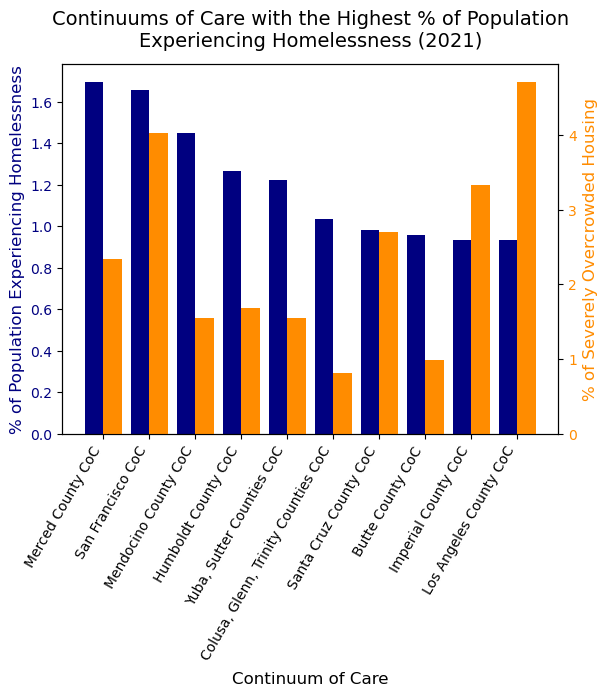

In [270]:
# Bar chart comparing severely overcrowded housing and homelessness for CoCs with the highest % homeless in 2021

# Create limited dataframe for 2021, sort in descending order by % homeless and isolate the top 10 CoCs
homeless_top10 = final_df[['Continuum of Care', '% Homeless', '% Units Severely Overcrowded']][final_df['Year'] == 2021]
homeless_top10 = homeless_top10.sort_values(by='% Homeless',ascending=False).iloc[:10]

# Define parameters for function
parems = {'x': 'Continuum of Care',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Severely Overcrowded Housing',
          'title': 'Continuums of Care with the Highest % of Population Experiencing Homelessness (2021)',
          'colors': ['navy', 'darkorange'],
          'rot': 60,
          'png_path': 'output_data/housing_overcrowding_bar.png'
         }

plot_bar_2y(homeless_top10, parems)

In [ ]:
def plot_box_whiskers(y_values, labels):
    
    fig1, ax1 = plt.subplots()
    ax1.set_ylabel(labels['y'])
    ax1.boxplot(y_values)
    plt.show()

### Homelessness and Severly Overcrowding Housing

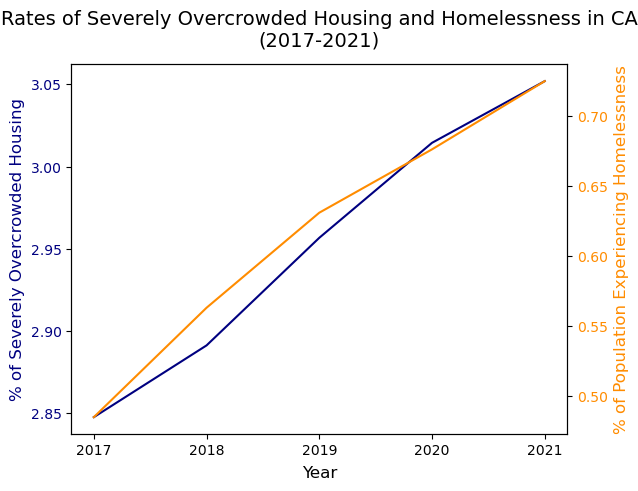

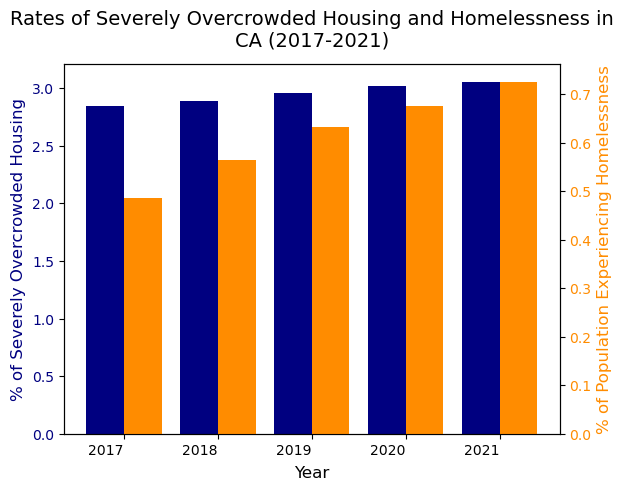

In [271]:
# Line chart comparing annual %s for severely overcrowded housing and homelessness between 2017 and 2021

# Create dataframe totalling numbers for each year and calculating %s
fig_data = final_df[['Year', 'Population', 'Homeless Count', 'Total Housing Units', 'Units Severely Overcrowded']].groupby('Year' , as_index = False).sum()
fig_data['% Units Severely Overcrowded'] = (fig_data['Units Severely Overcrowded'] /
                                            fig_data['Total Housing Units']) * 100

fig_data['% Homeless'] = fig_data['Homeless Count'] / fig_data['Population'] * 100
fig_data = fig_data[['Year', '% Units Severely Overcrowded', '% Homeless']]

# Define parameters for function
parems = {'x': 'Year',
          'y1': '% of Severely Overcrowded Housing',
          'y2': '% of Population Experiencing Homelessness',
          'title': 'Rates of Severely Overcrowded Housing and Homelessness in CA (2017-2021)',
          'colors': ['navy', 'darkorange'], 'rot': 0,
          'png_path': 'output_data/housing_overcrowding_bar.png'
         }

plot_line_2y(fig_data, parems)

plot_bar_2y(fig_data, parems)

The correlation is: 0.06577725529301554
The r value is: 0.06577725529301552
The p value is: 0.3487362119573699


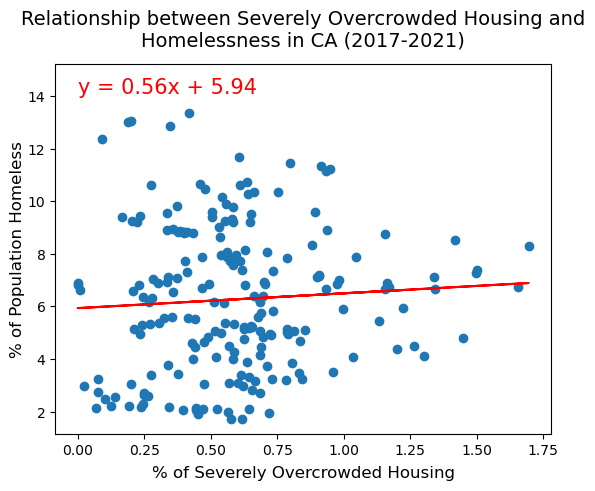

In [236]:
# Linear regression comparing Severely Overcrowded Housing and Homelessness

# Set parameters for function
parems = {'x': '% of Severely Overcrowded Housing',
          'y': '% of Population Homeless',
          'title': 'Relationship between Severely Overcrowded Housing and Homelessness in CA (2017-2021)',
          'png_path': 'output_data/housing_overcrowding_linreg.png'
         }

# Set x and y values
x_values = final_df['% Homeless']
y_values = final_df['% Units All Overcrowded']

# Call function to plot linear regression
plot_lin_reg(x_values, y_values, parems)

#plot_box_whiskers(final_df['% Homeless'], labels)

The correlation is: -0.0969642891826635
The r value is: -0.0969642891826635
The p value is: 0.5570514620445643


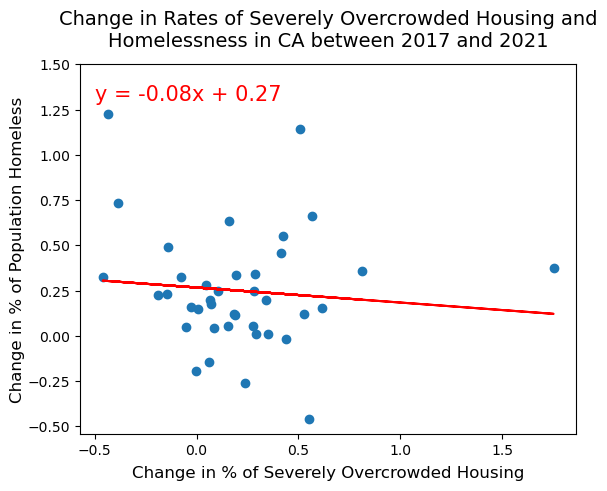

In [257]:
# Linear regression comparing change in severely overcrowded housing and homelessness between 2 years

# Set years for comparison
year1 = 2017
year2 = 2021
data_y1 = final_df[final_df['Year'] == year1].reset_index()
data_y2 = final_df[final_df['Year'] == year2].reset_index()

# Set parameters for function
parems = {'x': 'Change in % of Severely Overcrowded Housing',
          'y': 'Change in % of Population Homeless',
          'title': f'Change in Rates of Severely Overcrowded Housing and Homelessness in CA between {int(year1)} and {int(year2)}',
          'png_path': 'output_data/housing_overcrowding_linreg.png'
         }

# Calculate % change from year 1 to year 2
x_values = data_y2['% Units Severely Overcrowded'] - data_y1['% Units Severely Overcrowded']
y_values = data_y2['% Homeless'] - data_y1['% Homeless']

x_values = x_values.drop([x_values.index[12], x_values.index[16]])
y_values = y_values.drop([y_values.index[12], y_values.index[16]])
x_values.reset_index()
y_values.reset_index()

# Call function to plot linear regression
plot_lin_reg(x_values, y_values, parems)

### Homelessness and Housing Cost Burden
Housing costs burden is defined as housing costs are greater than 30% of household income)

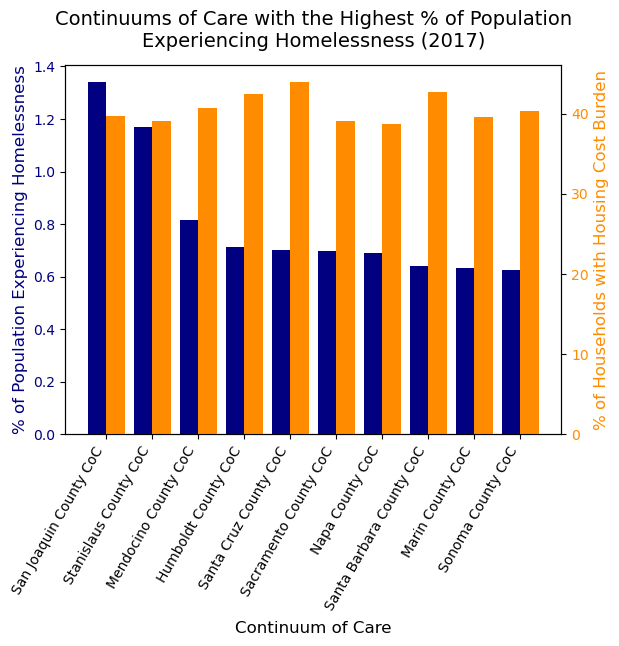

In [272]:
# Bar chart comparing severely overcrowded housing and homelessness for CoCs with the highest % homeless in 2021

# Create limited dataframe for 2021, sort in descending order by % homeless and isolate the top 10 CoCs
year = 2017
homeless_top10 = final_df[['Continuum of Care', '% Homeless', '% Units Costs >= 30%']][final_df['Year'] == year]
homeless_top10 = homeless_top10.sort_values(by='% Homeless',ascending=False).iloc[:10]

# Set parameters for function
parems = {'x': 'Continuum of Care',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Households with Housing Cost Burden',
          'title': f'Continuums of Care with the Highest % of Population Experiencing Homelessness ({year})',
          'colors': ['navy', 'darkorange'],
          'rot': 60,
          'png_path': 'output_data/housing_cost_burden_bar.png'
         }

plot_bar_2y(homeless_top10, parems)

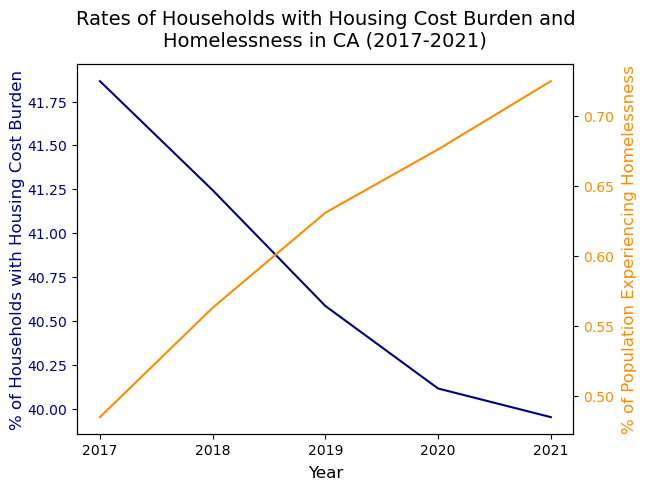

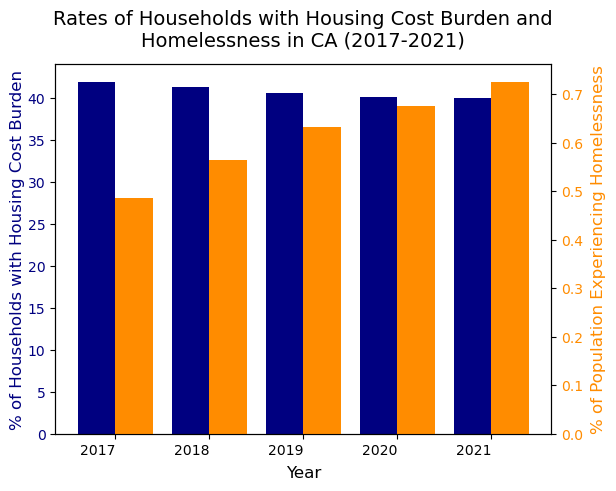

In [251]:
# Line chart comparing annual %s for severely overcrowded housing and homelessness between 2017 and 2021

# Create dataframe totalling numbers for each year and calculating %s
fig_data = final_df[['Year', 'Population', 'Homeless Count', 'Total Housing Units', 'Units Costs >= 30%']].groupby('Year' , as_index = False).sum()
fig_data['% Units Costs >= 30%'] = (fig_data['Units Costs >= 30%'] /
                                  fig_data['Total Housing Units']) * 100
fig_data['% Homeless'] = fig_data['Homeless Count'] / fig_data['Population'] * 100
fig_data = fig_data[['Year', '% Units Costs >= 30%', '% Homeless']]

# Set parameters for function
parems = {'x': 'Year',
          'y1': '% of Households with Housing Cost Burden',
          'y2': '% of Population Experiencing Homelessness',
          'title': 'Rates of Households with Housing Cost Burden and Homelessness in CA (2017-2021)',
          'colors': ['navy', 'darkorange'], 'rot': 0,
          'png_path': 'output_data/housing_cost_burden_bar.png'
         }

plot_line_2y(fig_data, parems)

plot_bar_2y(fig_data, parems)

The correlation is: -0.010747924595925816
The r value is: -0.010747924595925816
The p value is: 0.8784374684784902


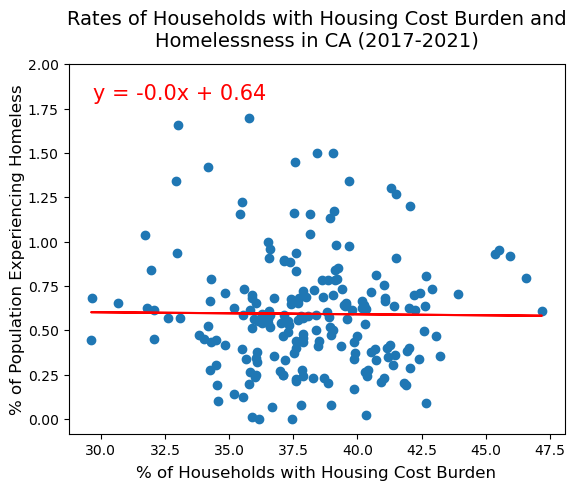

In [265]:
# Linear regression comparing households with housing cost burden and homelessness

# Define parameters for function
parems = {'x': '% of Households with Housing Cost Burden',
          'y': '% of Population Experiencing Homeless',
          'title': 'Rates of Households with Housing Cost Burden and Homelessness in CA (2017-2021)',
          'png_path': 'output_data/housing_cost_burden_linreg2.png'
         }

# Set x and y values
x_values = final_df['% Units Costs >= 30%']
y_values = final_df['% Homeless']

# Call function to plot linear regression
plot_lin_reg(x_values, y_values, parems)

#plot_box_whiskers(x_values, parems)

The correlation is: -0.03876530611783484
The r value is: -0.038765306117834845
The p value is: 0.8098394355208359


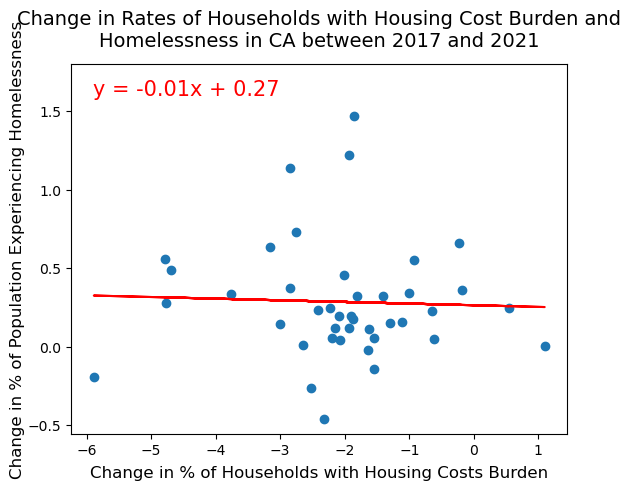

In [264]:
# Linear regression comparing change in housing cost burden and homelessness between 2 years

# Set years for comparison
year1 = 2017
year2 = 2021
data_y1 = final_df[final_df['Year'] == year1].reset_index()
data_y2 = final_df[final_df['Year'] == year2].reset_index()

# Set parameters for function
parems = {'x': 'Change in % of Households with Housing Costs Burden',
          'y': 'Change in % of Population Experiencing Homelessness',
          'title': f'Change in Rates of Households with Housing Cost Burden and Homelessness in CA between {int(year1)} and {int(year2)}',
          'png_path': 'output_data/housing_cost_burden_linreg2.png'
         }

# Calculate % change from year 1 to year 2
x_values = data_y2['% Units Costs >= 30%'] - data_y1['% Units Costs >= 30%']
y_values = data_y2['% Homeless'] - data_y1['% Homeless']

# Call function to plot linear regression
plot_lin_reg(x_values, y_values, parems)

## Test Visualizations

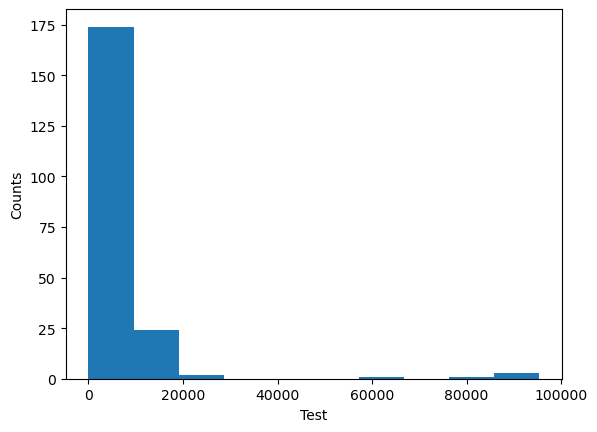

NormaltestResult(statistic=254.96596945304643, pvalue=4.313633037331286e-56)


In [276]:
# For testing normal distribution of any data
#file_path = Path('output_data/housing_homeless_data.csv')
#housing_homeless_df = pd.read_csv(file_path)

test_data = final_df['Homeless Count']
plt.hist(test_data)
plt.xlabel('Test')
plt.ylabel('Counts')
plt.show()
print(st.normaltest(test_data))

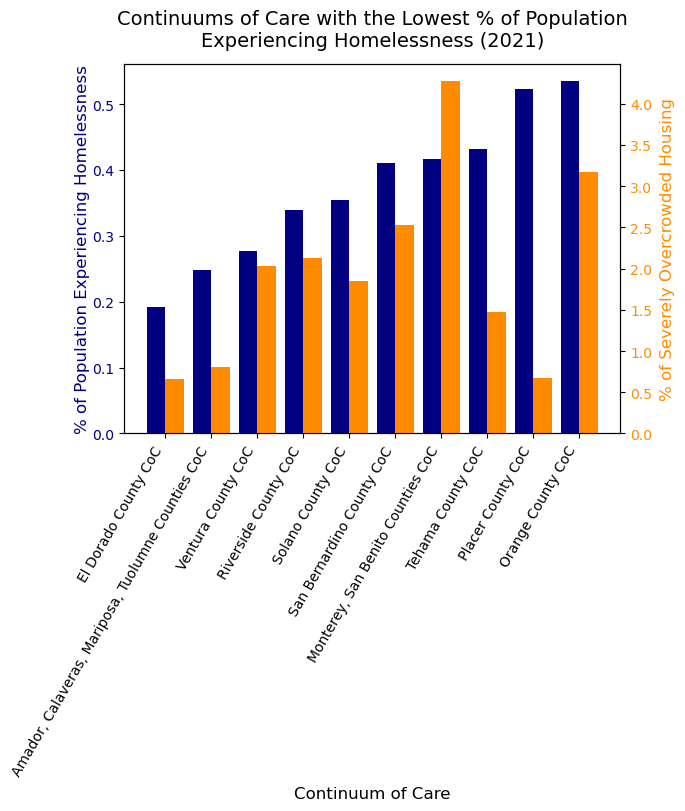

In [209]:
# Bar chart comparing severely overcrowded housing and homelessness for CoCs with the lowest % homeless in 2021

# Create limited dataframe for 2021, sort in descending order by % homeless and isolate the top 10 CoCs
homeless_bottom10 = final_df[['Continuum of Care', '% Homeless', '% Units Severely Overcrowded']][final_df['Year'] == 2021]
homeless_bottom10 = homeless_bottom10.sort_values(by='% Homeless',ascending=True).iloc[:10]

parems = {'x': 'Continuum of Care',
          'y1': '% of Population Experiencing Homelessness',
          'y2': '% of Severely Overcrowded Housing',
          'title': 'Continuums of Care with the Lowest % of Population Experiencing Homelessness (2021)',
          'colors': ['navy', 'darkorange'],
          'rot': 60,
          'png_path': 'output_data/housing_test.png'
         }

plot_bar_2y(homeless_bottom10, parems)